In [1]:
from functions import *
import numpy as np

In [2]:
## data path
path_raw = "./RAW Data/"
# profiles path
path_sim = "./Profiles/"
# DFT path
path_DFT = "./DFT/"

# load experimental data

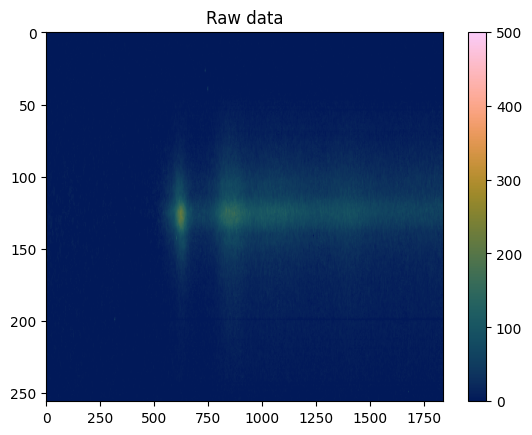

In [3]:
experiment = np.reshape(np.fromfile(path_raw + 'B-Kedge.dat', dtype='float32'), (256,1840))
plt.imshow(experiment,cmap=cmap,aspect='auto',vmin=0, vmax=5e2)
plt.colorbar()
plt.title('Raw data')
plt.show()

### Pre processing

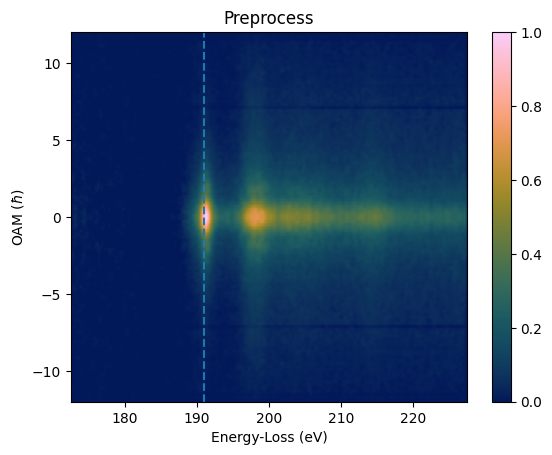

In [4]:
Bsub, x_ene, y_oam =  pre_process(experiment)
plt.xlabel('Energy-Loss (eV)')
plt.ylabel('OAM ($\hbar$)')
plt.imshow(Bsub, extent=(x_ene[0], x_ene[-1], y_oam[0], y_oam[-1]), aspect='auto', cmap=cmap, vmin=0, vmax=1)
plt.plot([191,191], [y_oam[0], y_oam[-1]], '--')
plt.colorbar()
plt.title('Preprocess')
plt.show()

### Prepare the experimental psf

In [5]:
# Load the Zero-loss 2D spectrum
ZL_raw = np.reshape(np.fromfile(path_raw + 'ZeroLoss.dat', dtype='float32'), (256,1024))
ZL,eneZL = pre_processZL(ZL_raw,Bsub.shape[0]+8)

# create a 1D psf from ZL 
psf = np.sum(ZL[:,30:40],1)
psf = psf/psf.sum()

# create the profiles at 191 eV and 198 eV from X
pi_star = savgol_filter(np.sum(Bsub[:,620//bin2:630//bin2],1), 5, 1, mode = 'nearest')
sigma_star = savgol_filter(np.sum(Bsub[:,850//bin2:870//bin2],1), 5, 1, mode = 'nearest')

# Discretize OAM spectrum

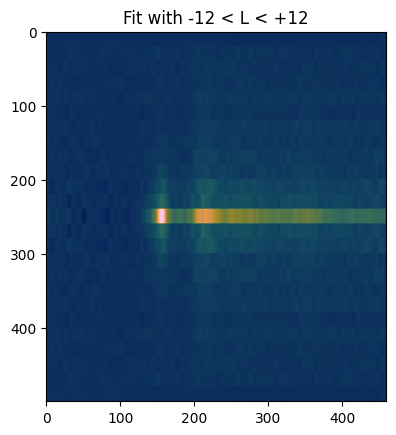

In [6]:
lmax = 12

L_fit = np.zeros((y_oam.size, 2*lmax + 1))
for i in range (2*lmax + 1):
    L_fit[:,i] = np.roll(psf,(i-lmax)*5)
A2 = L_fit

B2 = np.zeros((2*lmax+1,Bsub.shape[1]))

for i in range(Bsub.shape[1]):
    B2[:,i] = np.linalg.pinv(A2) @ Bsub[:,i]

plt.figure()
plt.imshow(np.repeat(B2,20,axis=0), cmap=cmap)
plt.title('Fit with -{} < L < +{}'.format(lmax,lmax))
plt.show()

### generate FIGURE 2 of the manuscript

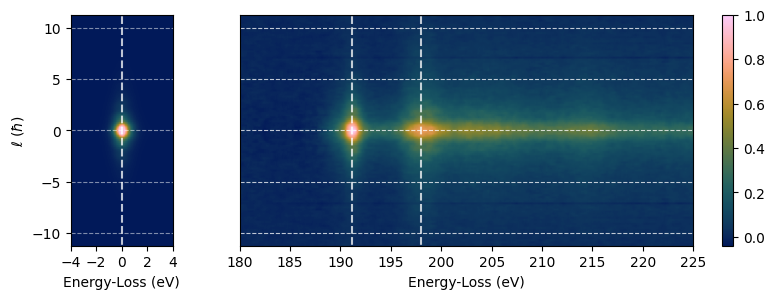

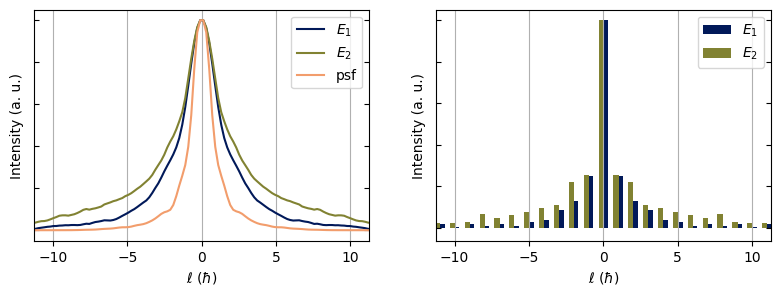

In [7]:
line1 = B2[:,148:158].sum(1) + 0*np.flip(B2[:,148:158].sum(1))
line2 = B2[:,205:215].sum(1) + 0*np.flip(B2[:,205:215].sum(1))

# Figure 2a,b
f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(9.5,3), width_ratios=[0.18,1])

plt.sca(axarr[0]); 
plt.imshow(ZL/np.max(ZL), extent=[np.min(eneZL), np.max(eneZL), np.min(y_oam), np.max(y_oam)], aspect='auto', cmap=cmap)
plt.xlabel('Energy-Loss (eV)')
plt.ylabel('$\ell$ ($\hbar$)')
plt.xlim([-4, 4])
plt.xticks([-4, -2, 0, 2, 4])
plt.ylim([-11.25, 11.25])
plt.yticks([-10, -5, 0, 5, 10])
plt.axvline(x=0, ymin=-11.25, ymax=11.25, linestyle='--', color='white', alpha=0.75)
plt.gca().yaxis.grid(True, linestyle='--', color='white', alpha=0.5)

plt.sca(axarr[1])
plt.imshow(Bsub, extent=[np.min(x_ene), np.max(x_ene), np.min(y_oam), np.max(y_oam)],
           aspect='auto', cmap=cmap)
plt.axvline(x=191.2, ymin=-11.25, ymax=11.25, linestyle='--', color='white', alpha=0.75)
plt.axvline(x=198, ymin=-11.25, ymax=11.25, linestyle='--', color='white', alpha=0.75)
plt.xlabel('Energy-Loss (eV)')
plt.xlim([180, 225])
plt.ylim([-11.25, 11.25])
plt.gca().yaxis.grid(True, linestyle='--', color='white', alpha=0.75)
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=False, right=False, direction='in')
plt.colorbar()
plt.show()

# Figure 2c,d
f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(9.5,3), width_ratios=[1,1])
plt.sca(axarr[0]); 

plt.plot(y_oam, pi_star/np.max(pi_star), color=palette1[0])
plt.plot(y_oam, sigma_star/np.max(sigma_star), color=palette1[2])
plt.plot(y_oam, psf/np.max(psf), color=palette1[3])
plt.legend(['$E_{1}$', '$E_{2}$', 'psf'], loc = "upper right")
plt.xlabel('$\ell$ ($\hbar$)')
plt.ylabel('Intensity (a. u.)')
plt.xlim([-11.25, 11.25])
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=True, right=True, direction='in')
plt.gca().xaxis.grid(True)


# new profiles 11/11/2024
L0_MC = np.loadtxt(path_sim  + 'L0_ideal.dat', delimiter=' ')
L1p_MC = np.loadtxt(path_sim + 'L1_ideal.dat', delimiter=' ')
L1m_MC = np.loadtxt(path_sim + 'L-1_ideal.dat', delimiter=' ')

plt.sca(axarr[1]); 
plt.bar([s + 0.15 - lmax for s in range (2*lmax + 1)], line1/line1.max(), width=0.35, label='$E_{1}$', color = palette1[0])
plt.bar([s - 0.15 - lmax for s in range (2*lmax + 1)], line2/line2.max(), width=0.35, label='$E_{2}$', color = palette1[2])
plt.legend()
plt.xlabel('$\ell$ ($\hbar$)')
plt.ylabel('Intensity (a. u.)')
plt.xlim([-11.25, 11.25])
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=True, right=True, direction='in')
plt.gca().xaxis.grid(True)
plt.show()

# load simulated delocalized spectra.

In [8]:
L0_MC = np.loadtxt(path_sim  + 'L0_ideal.dat', delimiter=' ')
L1p_MC = np.loadtxt(path_sim + 'L1_ideal.dat', delimiter=' ')
L1m_MC = np.loadtxt(path_sim + 'L-1_ideal.dat', delimiter=' ')

### generate l plots for FIGURE 3b

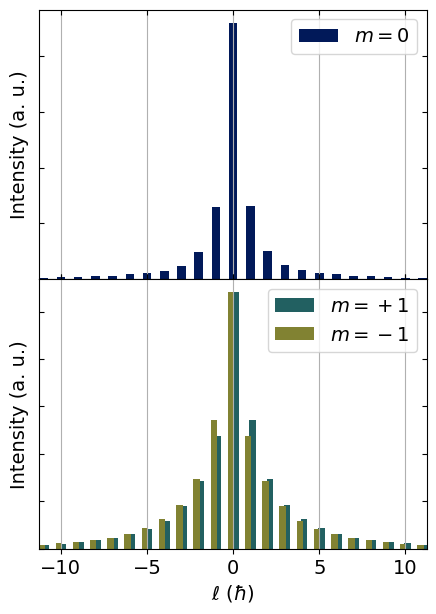

In [9]:
rcParams.update({'font.size': 14})

# Plot the results
f, axarr = plt.subplots(nrows=2, ncols=1, figsize=(5,7), sharex=True)
f.subplots_adjust(hspace=0)

plt.sca(axarr[0])
plt.bar(L0_MC[:,0], L0_MC[:,1]/np.sum(L0_MC[:,1]), color = palette1[0], width = 0.5)
plt.legend(['$m = 0$'], loc = "upper right")
plt.gca().xaxis.grid(True)
plt.xlim([-11.25, 11.25])
plt.gca().axes.tick_params(axis='x', bottom=True, top=True, direction='in')
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=True, right=True, direction='in')
plt.ylabel('Intensity (a. u.)')

plt.sca(axarr[1])
plt.bar(L1p_MC[:,0] + 0.125, L1p_MC[:,1]/np.sum(L1p_MC[:,1]), color = palette1[1], width=0.375)
plt.bar(L1m_MC[:,0] - 0.125, L1m_MC[:,1]/np.sum(L1m_MC[:,1]), color = palette1[2], width=0.375)
plt.legend(['$m = +1$', '$m = -1$'], loc = "upper right")
plt.gca().xaxis.grid(True)
plt.xlim([-11.25, 11.25])
plt.gca().axes.tick_params(axis='x', bottom=True, top=True, direction='out')
plt.xlabel('$\ell$ ($\hbar$)')
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=True, right=True, direction='in')
plt.ylabel('Intensity (a. u.)')
plt.show()

# Removing delocalisation effect

In [10]:
# prepare the OAM profile for the MLLS fit, 
# by convolving the simulated OAM frofile for the psf (to reduce noise)
rcParams.update({'font.size': 14})

n1 = 10//bin1

# m = 0
ind = np.int16(abs(L0_MC[0,0])- lmax)
L0_MC = L0_MC[ind:ind + 2*lmax + 1,:]
m1,nn = L0_MC.shape
L0d = np.zeros((n1*m1 - (n1-1)),dtype=L0_MC.dtype)
L0d[::n1] = L0_MC[:,1]
m2 = np.linspace(-lmax, lmax, np.size(L0d))

# m = +1
ind = np.int16(abs(L1p_MC[0,0])- lmax)
L1p_MC = L1p_MC[ind:ind + 2*lmax +1,:]
m1,nn = L1p_MC.shape
L1pd = np.zeros((n1*m1 - (n1-1)),dtype=L1p_MC.dtype)
L1pd[::n1] = L1p_MC[:,1]

# m = -1
ind = np.int16(abs(L1m_MC[0,0])- lmax)
L1m_MC = L1m_MC[ind:ind + 2*lmax +1,:]
m1,nn = L1m_MC.shape
L1md = np.zeros((n1*m1 - (n1-1)),dtype=L1m_MC.dtype)
L1md[::n1] = L1m_MC[:,1]

# perform convolution with psf
L0 = np.convolve(L0d, psf,'same') #use the experimental psf
L0 = np.delete(L0, 1, 0)
L1p = np.convolve(L1pd, psf,'same') #use the experimental psf
L1p = np.delete(L1p, 1, 0)
L1m = np.convolve(L1md, psf,'same') #use the experimental psf
L1m = np.delete(L1m, 1, 0)

# Stack the y_oam profile into the matrix A1
A1 = np.vstack((L0, L1p + L1m)).T

In [11]:
## perform MLLS fitting (to deconvolve the dataset)
C1 = Bsub.copy()

B1 = np.zeros((A1.shape[1], C1.shape[1]))

# Perform linear regression of the dataset
for i in range(C1.shape[1]):
    B1[:,i] = np.linalg.lstsq(A1, C1[:,i], rcond=None)[0]

# generate 2D plot for FIGURE 4a
m,n = np.shape(Bsub)
n1 = 20

Lfit0 = np.zeros((lmax * 2 + 1, n))
Lfit1p = np.copy(Lfit0)
Lfit1m = np.copy(Lfit0)

Lfit1p[lmax, :] = savgol_filter(B1[1,:], 11, 1, mode='nearest')
Lfit0[lmax + 1, :] = savgol_filter(B1[0,:], 11, 1, mode='nearest')
Lfit1m[lmax + 2, :] = savgol_filter(B1[1,:], 11, 1, mode='nearest')

## FIGURE 4a

In [12]:
Ldec0 = savgol_filter(B2, 11, 1, mode='nearest')

size1 = Lfit0.shape

# OAM dispersion (1*hbar/n)
m1 = np.linspace(-lmax, lmax, (size1[0] - 1) * n1 + 1)

Lfit00 = np.zeros(((size1[0] - 1) * n1 + 1, size1[1]))
Lfit11p = np.zeros(((size1[0] - 1) * n1 + 1, size1[1]))
Lfit11m = np.zeros(((size1[0] - 1) * n1 + 1, size1[1]))

Ldec = np.zeros(((size1[0] - 1) * n1 + 1, size1[1]))

for l in range(0, size1[0]):
    Lfit00[n1 * (l - 1) + 1, :] = Lfit0[l, :]
    Lfit11p[n1 * (l - 1) + 1, :] = Lfit1p[l, :]
    Lfit11m[n1 * (l - 1) + 1, :] = Lfit1m[l, :]
    Ldec[n1 * l  , :] = Ldec0[l, :]
    
Lfit = Lfit00 + Lfit11p + Lfit11m
Lfit = Lfit/np.max(Lfit)
Ldec = Ldec/np.max(Ldec)

# dispersions values
de = np.abs(x_ene[0] - x_ene[1])
dm = 1/n1

# calculate theoretical psf
wg = 1.1*0.82  # expected max. resolution
wl = 0.0
psf_th = voigt_profile(m1, wg/2.35482, wl)
psf_th = psf_th/np.sum(psf_th)

psfi = voigt_profile(m1, 0.2/2.35482, wl) # zero resolution for plotting
psfi = psfi/np.sum(psfi)

vf = wl/2 + np.sqrt(wl**2/4 + wg**2) # voight FWHM
res = vf/0.82                        # resolution

## Perform theoretical convolution (Energy and OAM)

# OAM convolution with psf
A1 = convolve1d(Lfit, psf_th, axis=0, mode='constant', cval = 0.0)
A1 /= np.sum(A1)

I1 = convolve1d(Lfit, psfi, axis=0, mode='constant', cval = 0.0)
I1 /=np.sum(I1)

A2 = convolve1d(Ldec, psf_th, axis=0, mode='constant', cval = 0.0) 
A2 /= np.sum(A2)

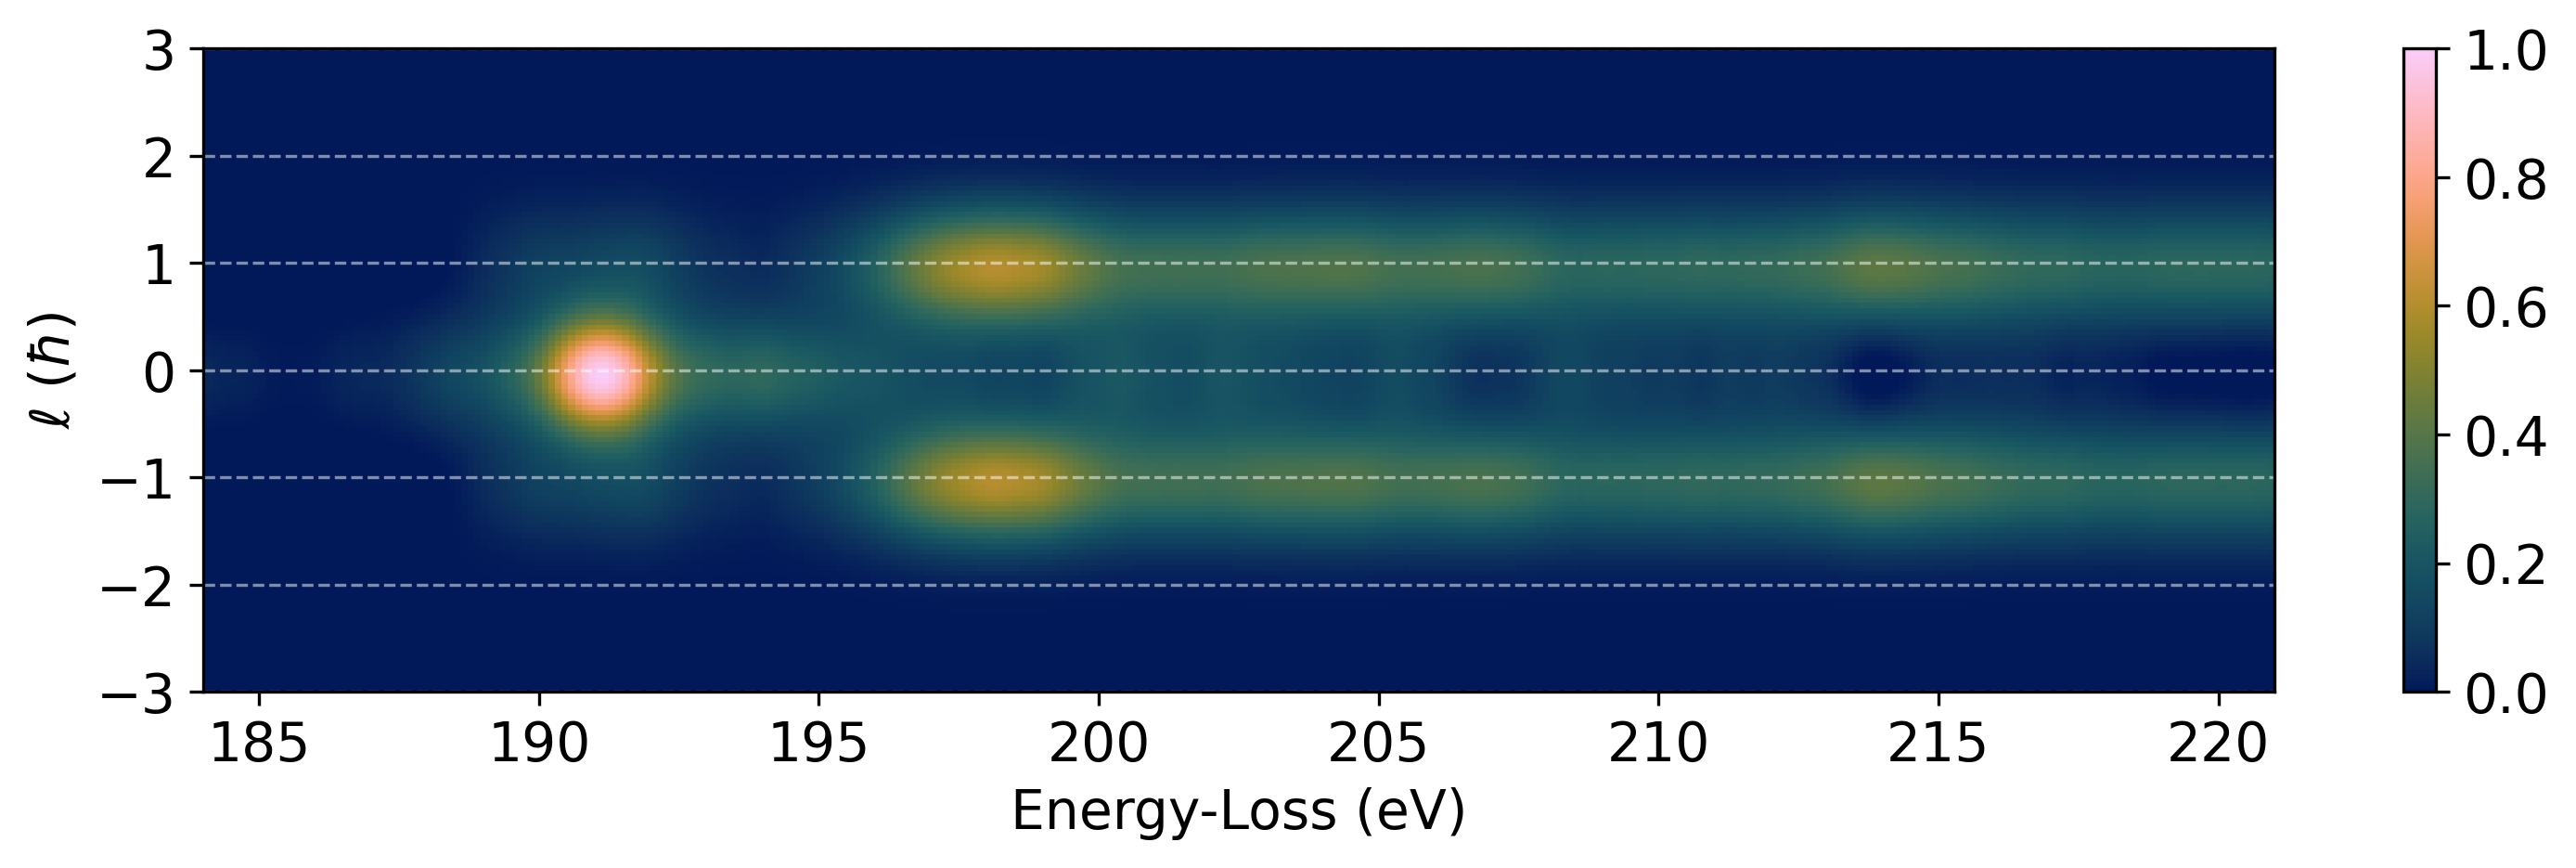

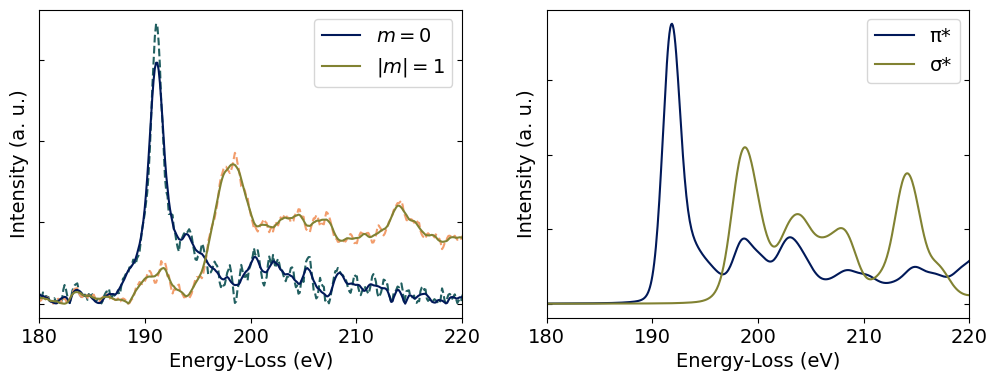

In [13]:
## generate FIGURE 4
# Figure 4a
plt.figure(figsize=(12, 3), dpi=300)
plt.imshow(A1/np.max(A1), vmin=0, vmax=1, extent=[np.min(x_ene), np.max(x_ene), np.min(m1), np.max(m1)],
           aspect='auto', cmap=cmap)
plt.xlabel('Energy-Loss (eV)')
plt.ylabel('$\ell$ ($\hbar$)')
plt.xlim([184, 221])
plt.yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.ylim([-3, 3])
plt.gca().yaxis.grid(True, linestyle='--', color='white', alpha=0.5)
plt.colorbar()
#plt.title('Real OAM-EELS')

# Figure 4b,c
f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

plt.sca(axarr[0]);
plt.plot(x_ene, np.abs(B1[0,:]), '--', color = palette1[1])
plt.plot(x_ene, np.abs(B1[1,:]), '--', color = palette1[3])
plt.plot(x_ene, np.abs(savgol_filter(B1[0,:], 9, 1, mode='interp')), label = '$m = 0$', color = palette1[0])
plt.plot(x_ene, np.abs(savgol_filter(B1[1,:], 9, 1, mode='interp')), label = '$|m| = 1$', color = palette1[2])
plt.legend(loc = "upper right")
plt.xlabel('Energy-Loss (eV)')
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=True, right=True, direction='in')
plt.ylabel('Intensity (a. u.)')
plt.xlim(180, 220)
#plt.title('experiment')

## Plot theoretical DFT spectra of Boron K edge
# load DFT spectra of Boron K edege (with core hole = 0.5)
hBN_001 = np.loadtxt(path_DFT + 'xanes_001h_0.5.dat', skiprows=4)
hBN_100 = np.loadtxt(path_DFT + 'xanes_100h_0.5.dat', skiprows=4)

onset = 188          # experimental onset of B-K edge (eV)
Ef = 5.9280          # Fermi Energy (DFT) (not used here) (eV)
ene = hBN_001[:, 0]  # energy-loss (eV)

# Gaussian convolution (energy spread in the experiment)
fwhm = 1.8    # FWHM (eV)
sigma = fwhm / 2.35482  # standard deviation (eV)
x0 = (np.max(ene) + np.min(ene)) / 2
gauss = np.exp(-1 * (ene - x0) ** 2 / (2 * sigma ** 2))
gauss /= np.sum(gauss)

# convolve the theoretical spectra 
pz  = np.convolve(hBN_001[:, 1], gauss, 'same')
pxy = np.convolve(hBN_100[:, 1], gauss, 'same')

# Plot hBN B-K spectra (DFT with energy convolution)
plt.sca(axarr[1]);
plt.plot(ene + onset, pz, color = palette1[0])
plt.plot(ene + onset, pxy, color = palette1[2]) # 2* if you want to to account for the 4 electrons instead of 2
plt.legend(['π*', 'σ*'])
plt.xlim(180, 220)
plt.xlabel('Energy-Loss (eV)')
plt.gca().axes.set_yticklabels([])
plt.gca().axes.tick_params(axis='y', left=True, right=True, direction='in')
plt.ylabel('Intensity (a. u.)')
#plt.title('simulated hBN B-K edge (with energy convolution)')
plt.show()

## generate m = +1 plots for FIGURE 3a 

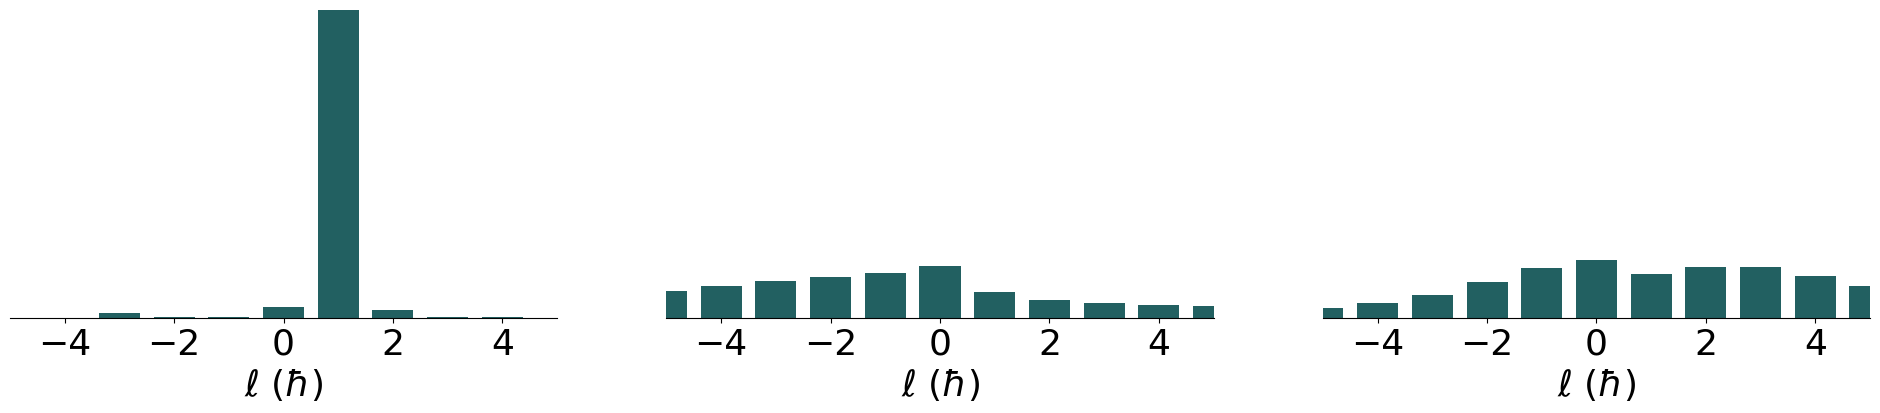

In [14]:
rcParams.update({'font.size': 26})

at0 = np.loadtxt(path_sim  + 'prof0.dat', delimiter=' ')
at1 = np.loadtxt(path_sim  + 'prof1.dat', delimiter=' ')
at2 = np.loadtxt(path_sim  + 'prof2.dat', delimiter=' ')

at0_flip = -1*at0[:,0] # the output has opposite orientation of OAM
atot = at0[:,1] + at1[:,1] + at2[:,1] # total contribution (not used)
atot = atot/np.sum(atot)

f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(24,4))
wd = 0.75 # bar width in the plot

plt.sca(axarr[0])
plt.bar(at0_flip, 2*at0[:,1]/np.sum(at0[:,1]), width=wd, color = palette1[1])
ax=plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.xlabel('$\ell$ ($\hbar$)')
plt.xlim([-5, 5])
plt.ylim([0, 1.05])

plt.sca(axarr[1])
plt.bar(at0_flip, 2*at1[:,1]/np.sum(at1[:,1]), width=wd, color = palette1[1]) # 2x plotting
ax=plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.xlabel('$\ell$ ($\hbar$)')
plt.xlim([-5, 5])
plt.ylim([0, 1.05])

plt.sca(axarr[2])
plt.bar(at0_flip, 2*at2[:,1]/np.sum(at2[:,1]), width=wd, color = palette1[1]) # 2x plotting
ax=plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.xlabel('$\ell$ ($\hbar$)')
plt.xlim([-5, 5])
plt.ylim([0, 1.05])
plt.show()

## generate FIGURE 1c from DFT spectra

max. resolution =  1.1


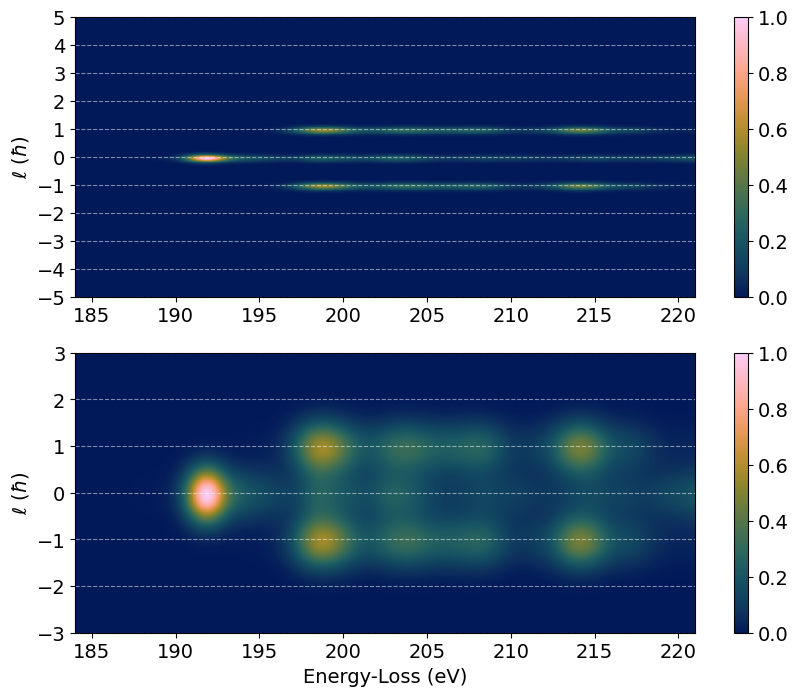

In [15]:
n = 20     # determines the dispersion as hbar/n
N = len(ene)

prob0 = np.zeros((lmax * 2 + 1, N))
prob1p = np.copy(prob0)
prob1m = np.copy(prob0)

prob1p[lmax, :] = pxy
prob0[lmax + 1, :] = pz
prob1m[lmax + 2, :] = pxy

size1 = prob0.shape
m = np.array([-lmax, 0, lmax])

# OAM dispersion (1*hbar/n)
m1 = np.linspace(-lmax, lmax, (size1[0] - 1) * n + 1)

prob1 = np.zeros(((size1[0] - 1) * n + 1, size1[1]))

prob00 = np.copy(prob1)
prob11p = np.copy(prob1)
prob11m = np.copy(prob1)

for l in range(2, size1[0]):
    prob00[n * (l - 1) + 1, :] = prob0[l, :]
    prob11p[n * (l - 1) + 1, :] = prob1p[l, :]
    prob11m[n * (l - 1) + 1, :] = prob1m[l, :]

prob1 = prob00 + prob11p + prob11m
prob1 = prob1/np.max(prob1)

# dispersions values
de = np.abs(ene[0] - ene[1])
dm = 1/n

# calculate theretical psf
wg = 1.1*0.82  # expected max. resolution
wl = 0.0
psf_th = voigt_profile(m1, wg/2.35482, wl)
#psf = voigt_profile(m1, 0.6, 0.4)
psf_th = psf_th/np.sum(psf_th)

psfi = voigt_profile(m1, 0.2/2.35482, wl) # zero resolution for plotting
psfi = psfi/np.sum(psfi)

vf = wl/2 + np.sqrt(wl**2/4 + wg**2) # voight FWHM
res = vf/0.82                        # resolution

print('max. resolution = ', res)

## Perform theoretical convolution (Energy and OAM) FIGURE1
rcParams.update({'font.size': 14})

# OAM convolution with psf
A = convolve1d(prob1, psf_th, axis=0, mode='constant', cval = 0.0)
A /= np.sum(A)
I = convolve1d(prob1, psfi, axis=0, mode='constant', cval = 0.0)
I /=np.sum(I)

## Plot 2D EELS
f, axarr = plt.subplots(nrows=2,ncols=1, figsize=(10,8))

# ideal case (I)
plt.sca(axarr[0]); 
plt.imshow(I/np.max(I), extent=[np.min(ene + onset), np.max(ene + onset), np.min(m1), np.max(m1)], 
           aspect='auto', cmap=cmap)
#plt.title('OAM-EELS B-K edge (ideal)')
#plt.xlabel('Energy-Loss (eV)')
plt.ylabel('$\ell$ ($\hbar$)')
plt.xlim([184, 221])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.ylim([-3, 3])
#plt.title('Ideal OAM-EELS')
plt.yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.gca().yaxis.grid(True, linestyle='--', color='white', alpha=0.5)
plt.colorbar()

# real case (A)
plt.sca(axarr[1]); 
#plt.title('OAM-EELS B-K edge (after psf convolution)')
plt.imshow(A/np.max(A), extent=[np.min(ene + onset), np.max(ene + onset), np.min(m1), np.max(m1)],
           aspect='auto', cmap=cmap)
plt.xlabel('Energy-Loss (eV)')
plt.ylabel('$\ell$ ($\hbar$)')
plt.xlim([184, 221])
plt.yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.ylim([-3, 3])
plt.gca().yaxis.grid(True, linestyle='--', color='white', alpha=0.5)
plt.colorbar()
plt.show()